In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/ESTCampAI/Deeplearning/LangChain

/content/drive/MyDrive/ESTCampAI/Deeplearning/LangChain


- 의존성 라이브러리 설치

In [ ]:
!pip install -qU langchain langchain-core langchain-community langchain-openai
!pip install -qU langgraph

- API 키 등록

In [ ]:
api_key = ""

# 환경변수 등록
import os

# 추가 - 지정하고 대입
os.environ["OPENAI_API_KEY"] = api_key

# Single Agent
- 지금까지 사용한 구조
- 하나의 LLM 에이전트가 모든 요청을 처리

In [ ]:
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain.agents import create_agent
from typing import Literal # 타입힌트용 유틸 (특정 문자열만 입력으로 허용할 때 사용)
                        # Lieral["a", "b"] → 인자값으로 "a" 또는 "b"만을 입력으로 허용

In [ ]:
# 모델 초기화
llm = init_chat_model(
    model = "openai:gpt-4.1",
    temperature = 0,
    max_tokens = 500
    # 스트리밍 모드, 콜백 핸들러 생략
)

- 단일 에이전트에서 사용할 간단한 Tool 정의

In [ ]:
@tool
def get_weather(city : Literal["서울", "부산"]) -> str :
  """
  매우 단순한 날씨 조회 도구 (원래라면 날씨 API)
  """
  if city == "서울" :
    return "서울은 오늘 흐리고 약간 쌀쌀합니다."
  elif city == "부산" :
    return "부산은 오늘 맑고 따뜻합니다."
  else :
    raise ValueError("지원하지 않는 도시입니다.")

- 단일 ReAct 에이전트 구현
- `create_agent` : LangGraph 기반 ReAct 에이전트 그래프 생성

In [ ]:
# 사용할 tool list 정의
tools = [get_weather]

In [ ]:
# 싱글 에이전트 초기화
single_agent = create_agent(
    model = llm,
    tools = tools,
    system_prompt = (
        "당신은 한국 주요 도시의 날씨를 알려주는 친절한 AI 비서다."
        "모르는 정보는 지어내지 말고, 툴에서 제공된 정보만 바탕으로 답변해라"
    )
)

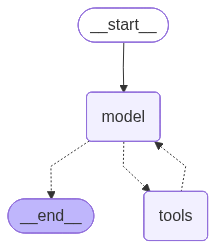

In [ ]:
single_agent

- Single Agent 실행 + 스트리밍 출력 헬퍼 함수
- `create_agent()`가 반환하는 에이전트는 LangGraph "그래프"이기 때문에 `.invoke()`, `.stream()` 둘 다 가능

In [ ]:
# 그래프 stream() 결과 받아서, 메세지 출력해주는 도구
def print_stream(stream) :
  for state in stream :
    message = state["messages"][-1] # 마지막 메세지
    message.pretty_print() # 랭체인에서 제공되는 메세지 출력 함수

- 단일 턴 예시 실행

In [ ]:
# 사용자 입력 정의
inputs = {"messages" : [("user", "서울 날씨 어때?")]}

In [ ]:
print_stream(single_agent.stream(inputs, stream_mode = "values"))

================================ Human Message =================================

서울 날씨 어때?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_tfEVZxZNHMrfYMC5vgJ3s9Ak)
 Call ID: call_tfEVZxZNHMrfYMC5vgJ3s9Ak
  Args:
    city: 서울
================================= Tool Message =================================
Name: get_weather

서울은 오늘 흐리고 약간 쌀쌀합니다.
================================== Ai Message ==================================

서울은 오늘 흐리고 약간 쌀쌀한 날씨입니다. 외출하실 때 가벼운 겉옷을 챙기시는 것이 좋겠습니다.


> 예를 들어, 단일 에이전트 + get_weather 하나인 상태에서는
> ```
> “서울 날씨 어때?”
> “부산은 어때?”
> ```
> 같은 요청은 깔끔하게 처리할 수 있음

- 하지만 <font color = "red">요구사항이 점점 늘어나면 문제</font>가 생김

> 예)
> “서울이랑 부산 날씨 비교해주고, 마지막에 영어로 한 문장 요약도 해줘.”

- 이걸 한 싱글 에이전트에 모든 툴을 몰아넣어서 처리하려고 하면
    1. <b>Tool 과다(Too many tools)</b>
        - 날씨 조회, 번역, 검색, DB 조회, 캘린더, 메일 발송…
        - <font color = "red">하나의 에이전트에 툴을 계속 추가</font>하다 보면 → LLM 입장에서는 “어떤 도구를 언제 써야 하는지” <font color = "red">판단이 점점 어려워짐</font>

    2. <b>컨텍스트(메시지 히스토리) 과부하</b>
        - 한 에이전트가 전체 대화 히스토리 모든 툴 호출 결과 요약/메모리까지 전부 다 안고 가야 할 수도 있음
        - 컨텍스트 길이가 길어질수록 <font color = "red">비용·속도 문제 발생</font>하면서, <font color = "red">중요한 정보만 골라 쓰기 어려움</font>
    
    3. <b>전문화 부족</b>
        - 기획자/리서처/번역가/수학전문가/개발자…
        - 각 역할에 요구되는 “톤 & 스킬”이 다름
        - <font color = "red">한 에이전트에게 모든 역할을 맡기면</font> → <font color = "red">답변이 애매</font>하게 섞이거나, 특정 영역에서만 잘하는 기형적인 결과가 나올 수 있음

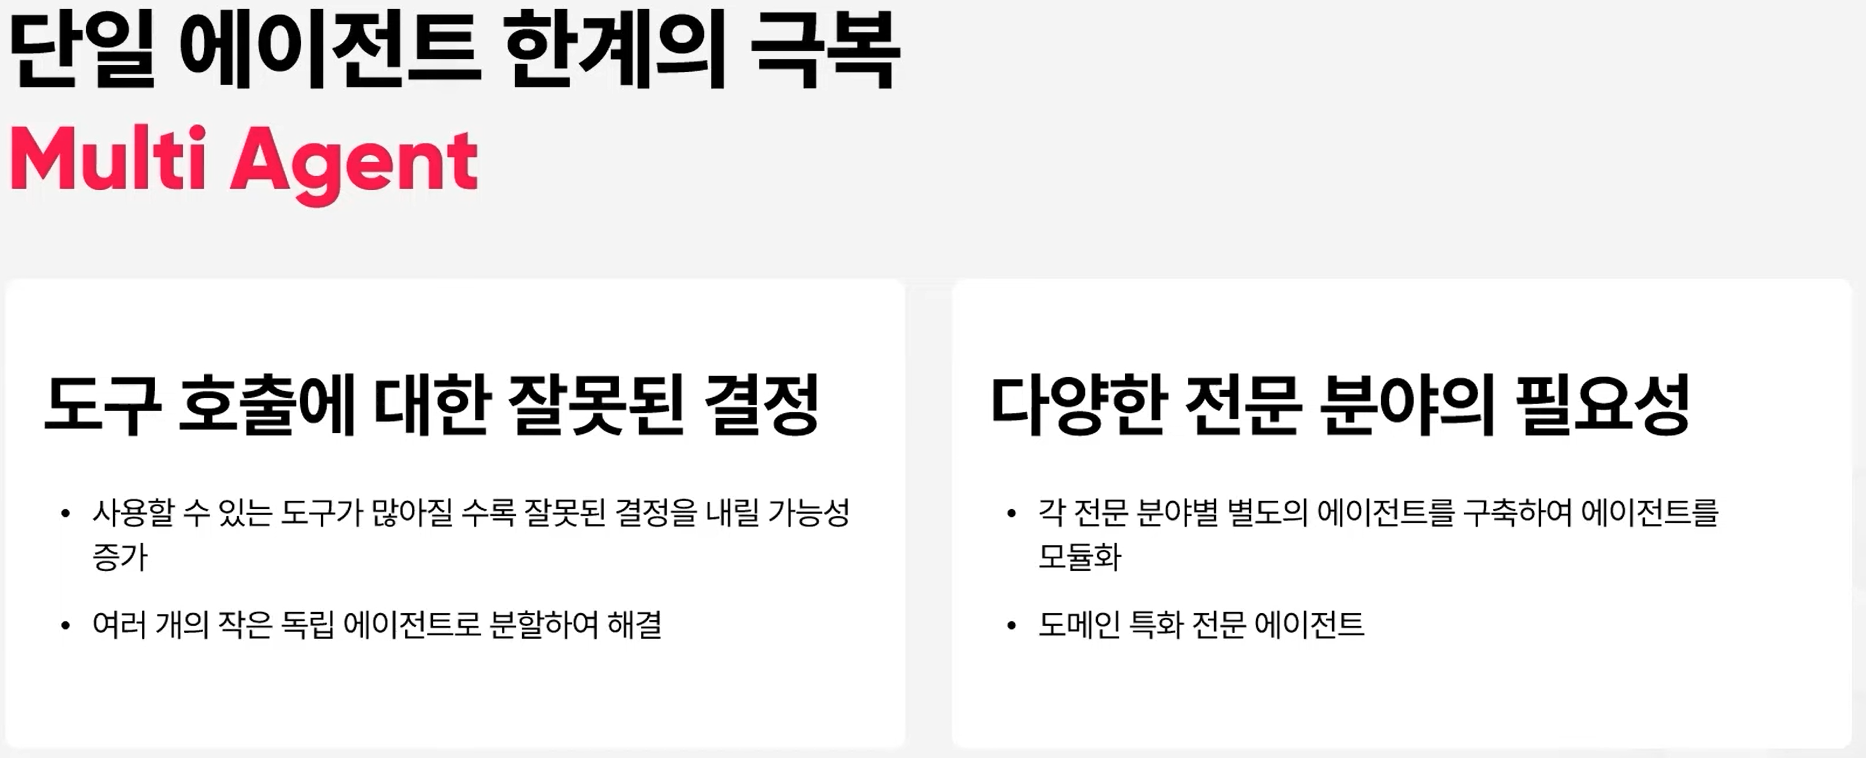

# Agent Architecture (에이전트 아키텍처)
- 보다 복잡한 워크플로우를 구성하기 위해 여러 가지 **에이전트 아키텍처**를 조합해서 사용

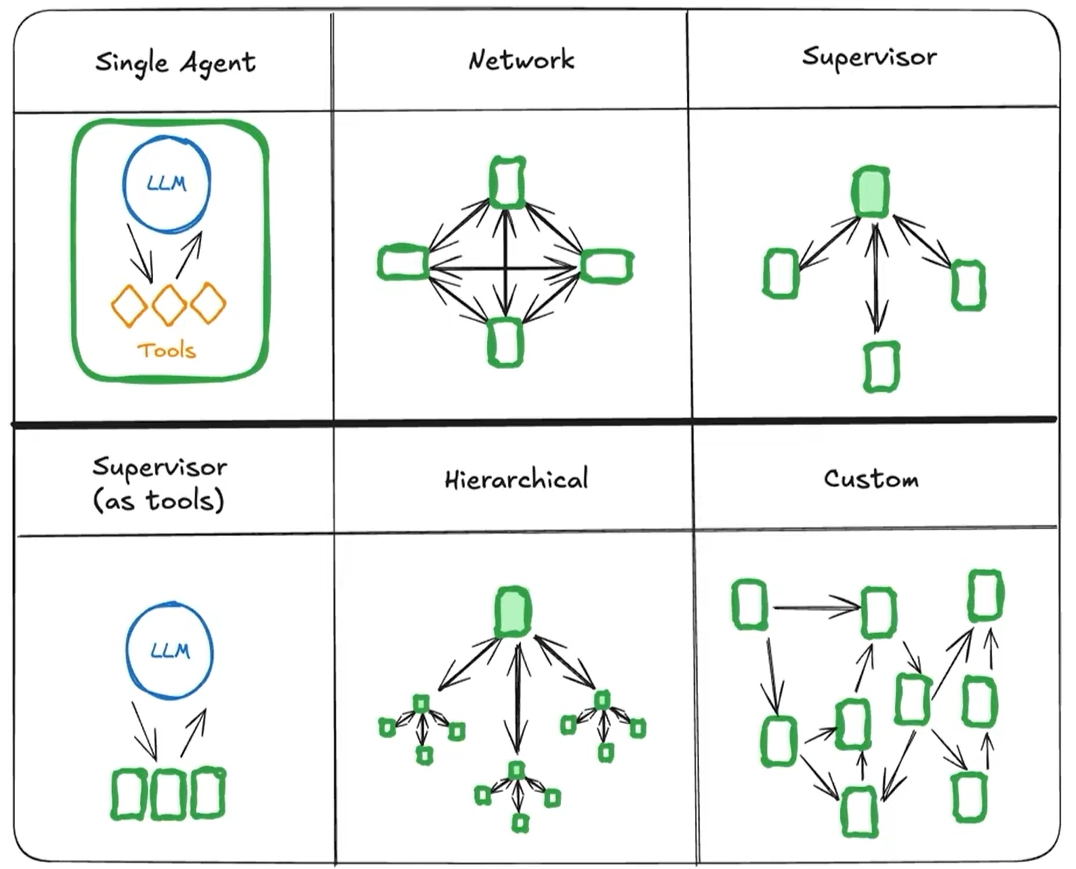

## Single Agent
- 지금까지 만든 `agent`에 대한 구조

> 하나의 에이전트가 `모델 호출`, `도구 호출`, `답변 생성` 등 모두 담당
> - 구조는 단순하지만, 도메인과 툴이 늘어날수록 관리가 어려워짐

## Network 구조

- **여러 에이전트들이 서로 연결된 상태**를 그래프처럼 구성
- 명확한 상하 관계가 없는 “에이전트 네트워크”

> 각 에이전트는 하나의 노드(node)로 표현되고, 에이전트 간 이동 (어느 에이전트가 다음으로 동작할지)은
> - 룰 기반(if/else)
> - 또는 LLM이 결정(conditional edge)

## Supervisor 구조

- **중앙의 Supervisor(감독자) 에이전트**가 존재

> 실제 작업은 여러 Worker 에이전트들이 담당
> - 예: `Researcher`, `MathExpert`, `Writer` 등

- Supervisor는 현재 상태를 보고 `어느 에이전트를 호출할지`, `언제 종료할지` 를 결정

## Supervisor(as Tools) 구조

- Supervisor가 **다른 에이전트들을 "툴"처럼 사용**하는 패턴

- 즉, Sub-Agent를 LangGraph/LangChain에서 **Tool로 래핑**해서
  - `controller_agent` → `subagent1_tool` 호출
  - `controller_agent` → `subagent2_tool` 호출
  식으로 구현
- “에이전트를 툴처럼 감싼다”는 점이 특징

## Hierarchical 구조

- Supervisor가 한 명이 아니라 `상위 Supervisor`, `하위 팀 Supervisor`, `그 아래 Worker 에이전트들…` 로 **계층 구조**를 이루는 패턴

> 예:
> - 최상위 Supervisor: “보험 상담 시스템 전체 책임”
> - 중간 Supervisor: “청구 처리 팀”, “상품 추천 팀”
> - 하위 에이전트: 실제 검색/분석/요약 담당

## Custom 구조

- 위 구조들을 섞어서 **서비스에 맞는 맞춤형 그래프**를 만드는 형태

> 예:
> - 상위 Supervisor + 하위 Network
> - Network 내부에서 Handoffs 활용
> - 특정 단계만 별도의 Subgraph로 분리 등

# 멀티 에이전트 – Supervisor 구조
> 단일 에이전트로 모든 툴과 도메인을 처리하는 대신, <br>
> 여러 개의 전문 에이전트(Worker) 를 두고 Supervisor(감독자) 가 <br>
> 이들을 조율하는 구조 → Supervisor 패턴

- LangGraph 공식 docs에서도 추천되는 대표 패턴

#### Single LLM Agnet

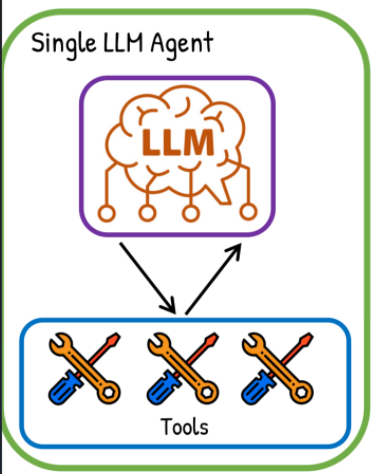


#### Multi Agent LLM System

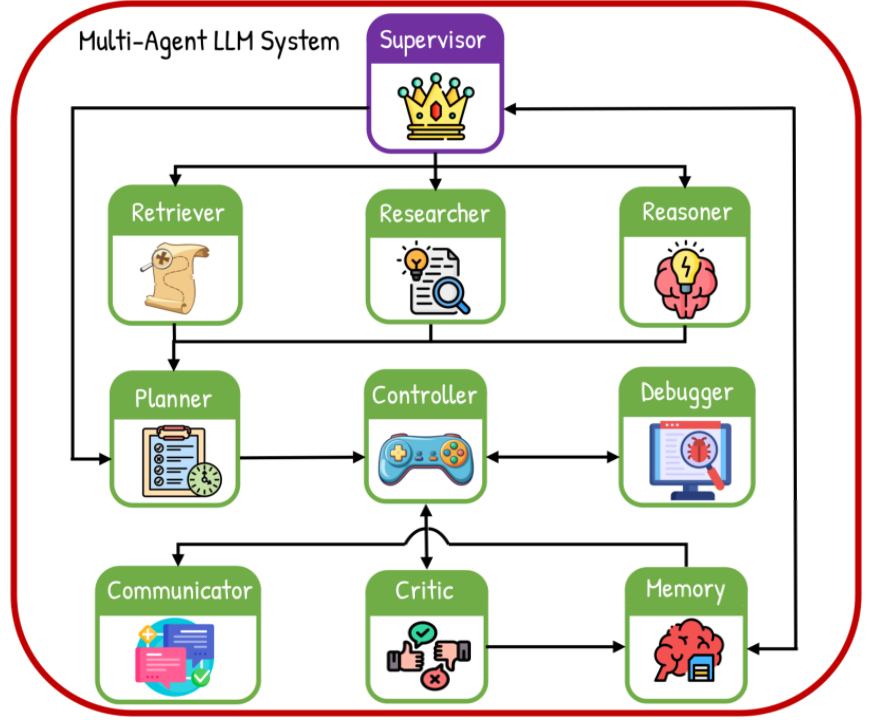

## 부모 그래프와 서브 그래프

#### 부모 그래프(Parent Graph)
- 전체 워크플로우를 관리하는 상위 그래프
- 여러 에이전트 또는 서브그래프들을 조합하여 하나의 큰 프로세스를 구성
- 전체 실행 순서와 흐름을 조율하는 “메인 컨트롤러” 역할
- 다양한 서브그래프를 호출하고, 그 결과를 통합하여 최종 응답 생성
- ex. `Entry Graph`

> 역할
> - 사용자 로그(logs)를 받아 처리 시작
> - 필요한 서브그래프를 호출 (예: Summarization, Failure Analysis)
> - 서브그래프 실행 결과를 통합해 최종 보고서 생성(summary report / failure report)
> - 전체 업무 플로우를 하나의 시스템으로 연결하는 “오케스트레이터”

---

#### 서브 그래프(Subgraph)
- 특정 역할을 수행하도록 설계된 작은 그래프
- ex. `Summarization(요약)`, `Failure Analysis(실패 분석)`
- 그 밖에도 번역, 문서 요약(summarization), RAG 검색, 오류 분석(failure analysis) 등 다양한 Task로 만들 수 있음

> 역할
> - 하나의 독립적인 컴포넌트처럼 동작 → Parent Graph에서 노드처럼 재사용 가능
> - 입력 상태(state)를 받아 내부에서 자체적인 처리 후 새로운 state 생성
> - 처리된 결과(summary report, failure report 등)를 parent에게 돌려줌

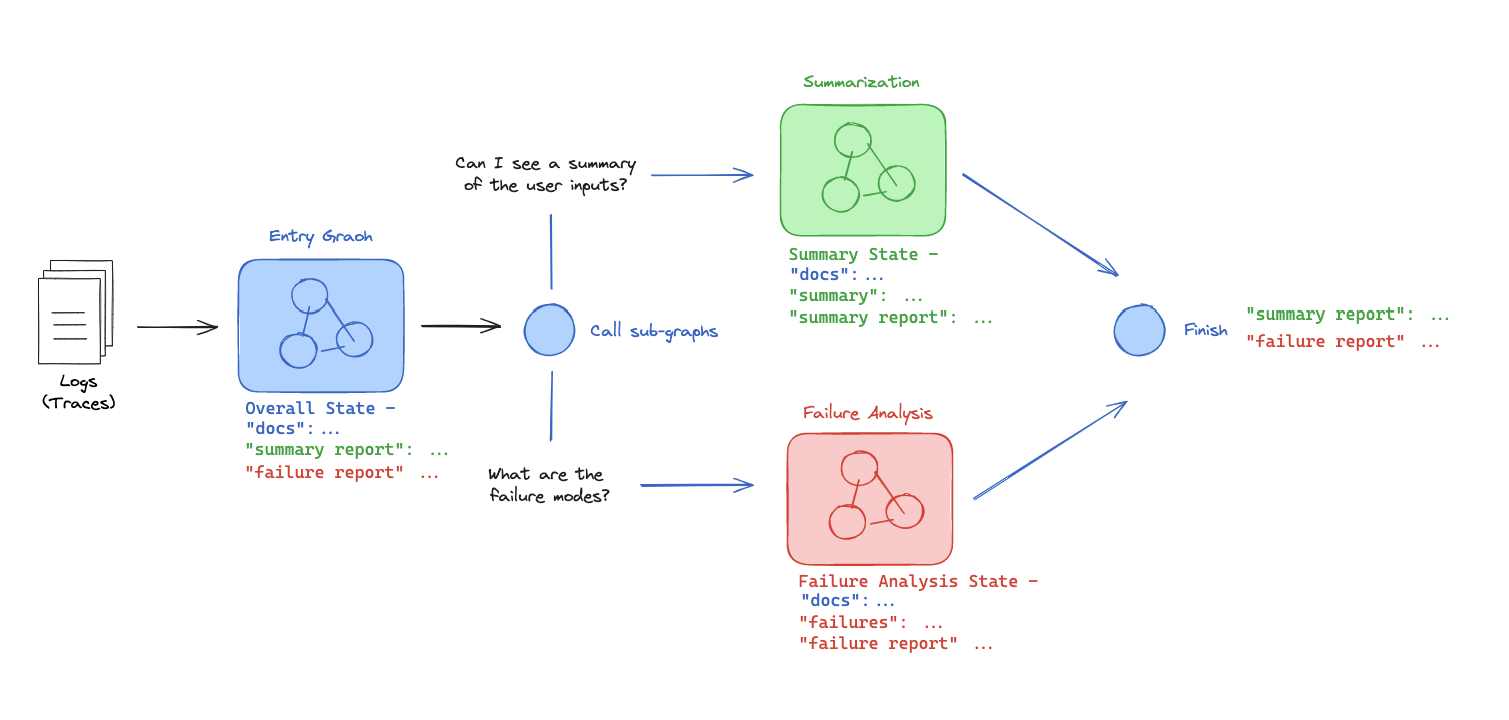

##### 🔁 흐름 예시

① Logs(입력 데이터) → Entry Graph(부모 그래프)
- 부모 그래프는 전체 처리의 시작점이며, 입력 데이터를 받아 초기 state를 설정
<br>

② Parent Graph → 서브그래프 호출 (Call subgraphs)
- 부모 그래프는 특정 요청/조건에 따라 **서브그래프를 호출**함
<br>

> 예시: <br>
> 사용자 문서를 요약해줘” → Summarization Subgraph 호출 <br>
> “이 문서에서 실패 원인을 분석해줘” → Failure Analysis Subgraph 호출

- 서브그래프는 부모 그래프의 일부처럼 작동하지만 **독립적인 처리 흐름**을 가짐
<br>

③ Subgraph → 결과 생성 후 Parent Graph로 복귀

> 서브그래프는 다음과 같은 state를 반환
> - Summarization Subgraph
>    - `"summary": ...`
>    - `"summary report": ...`
> - Failure Analysis Subgraph
>    - `"failures": ...`
>    - `"failure report": ...` <br>
>
> 이 값들이 통합되어 Parent Graph의 전체 state에 반영

<br>

④ Parent Graph → Finish(최종 결과)
- 부모 그래프는 모든 서브그래프의 결과를 합쳐 최종 결과를 만듬

> 이미지에서는 최종 state에 다음이 포함됨
> - `"summary report": ...`
> - `"failure report": ...`

# Multi Agent - Supervisor Agent 구현해보기

```
Supervisor Agent
   ├── Weather Agent (날씨 조회 전문가) → Tool 호출
   ├── Translator Agent (번역 전문가)
   └── Summary Agent (요약 전문가)
```

> Supervisor는 “사용자 요청을 해석 → 어떤 Worker 에이전트를 호출할지 결정 → 결과를 합쳐 최종 응답 생성”.

## LLM 없이, if/else 로 <b>plan 문자열</b> 만들어 보기

`LangGraph 적용 전 확인 실습`

- 멀티 에이전트의 핵심은 <font color = "red">어떤 작업 순서로 처리할지 계획(plan)을 정하는 것</font>
- 로우레벨 파이썬 함수로 구현 연습

> LangChain / LangGraph 공식 문서의 multi-agent 예제에서는 "라우터(router) 역할"이 필요함 <br>
> LLM 없이, 규칙 기반(if/else)으로만 계획(plan)을 세우는 연습 단계 <br>
> 나중에 LangGraph + 에이전트로 확장될 때, 이 함수가 Supervisor의 의사결정 기준(plan)이 되는 구조라고 보면 됨

In [ ]:
def extract_plan(user_text: str) -> str:
    """
    사용자 질문(문장)을 읽고, 이 요청을 어떤 ‘작업 단계(plan)’로 처리할지 결정하는 함수 정의
    """

    # 1) 도시 이름(서울, 부산)이 문장에 포함되어 있는지 검사
    has_city = any(city in user_text for city in ["서울", "부산"])

    # 2) 번역 관련 키워드가 포함되어 있는지 검사
    need_translate = any(k in user_text for k in ["영어", "번역", "영문"])

    # 3) 조건 조합에 따라 plan 문자열 결정

    # 3-1) 도시도 있고, 번역 키워드도 있는 경우 → 날씨 + 번역 둘 다 필요
    if has_city and need_translate:
        return "weather_then_translate"

    # 3-2) 도시만 있고, 번역 키워드는 없는 경우 → 날씨만 필요
    if has_city and not need_translate:
        return "weather_only"

    # 3-3) 도시는 없고, 번역 키워드는 있는 경우 → 번역만 필요
    if (not has_city) and need_translate:
        return "translate_only"

    # 3-4) 그 외: 도시도 없고, 번역 키워드도 없음 → Supervisor 입장에서는 바로 종료하는 플랜
    return "finish"

In [ ]:
# 함수 테스트 = plan을 반환하는 함수(지시서)
tests = [
    "서울 날씨 알려줘",
    "서울 날씨 알려주고 영어로 한 문장으로 번역해",
    "다음 문장을 영어로 바꿔줘 : 안녕하세요",
    "그냥 잡담이야"
]

for t in tests :
  print(t[:10], "... →", extract_plan(t))

서울 날씨 알려줘 ... → weather_only
서울 날씨 알려주고 ... → weather_then_translate
다음 문장을 영어로 ... → translate_only
그냥 잡담이야 ... → finish


## LLM 없이, <b>Supervisor 미니 버전</b> 만들어보기

`LangGraph 적용 전 확인 실습`

- 위에서 만든 plan 문자열(what to do)을 바탕으로, <b>현재 step 에서 어떤 일을 해야 할지</b>를 결정하는 결정하는 미니 Supervisor 구현해보기
-  함수 인자/반환값만으로 Supervisor의 의사결정 구조를 딕셔너리로만 구현 연습

> 이후에 LangGraph StateGraph에 들어가면
> - plan, step은 state 안에 들어가고
> - simple_supervisor가 결정한 값은 state["route"]에 저장되어
> - add_conditional_edges(...)에서 다음 노드(Worker)를 고르는 데 쓰이게 됨

In [ ]:
def simple_supervisor(plan: str, step: int) -> str:
    """
    plan + step 조합을 보고, 다음에 실행해야 하는 작업을 문자열로 반환하는 '미니 Supervisor'.
    """

    # 1) plan == "weather_only" 인 경우
    if plan == "weather_only":
        return "WEATHER_AGENT" if step == 0 else "FINISH"

    # 2) plan == "translate_only" 인 경우
    elif plan == "translate_only":
        return "TRANSLATOR_AGENT" if step == 0 else "FINISH"

    # 3) plan == "weather_then_translate" 인 경우
    elif plan == "weather_then_translate":
        if step == 0:
            return "WEATHER_AGENT"    # 첫 번째 단계: 날씨 조회 Worker 실행
        elif step == 1:
            return "TRANSLATOR_AGENT" # 두 번째 단계: 번역 Worker 실행
        else:
            return "FINISH"           # 그 이후 단계: 더 이상 할 일 없음

    # 4) 그 외(plan == "finish")
    return "FINISH"

In [ ]:
# 미니 수퍼바이저(simple_supervisor)가 의도한 대로 워크를 호출(문자열 반환)하는지

print(simple_supervisor("weather_only", 0))
print(simple_supervisor("weather_only", 1))

print(simple_supervisor("weather_then_translate", 0))
print(simple_supervisor("weather_then_translate", 1))
print(simple_supervisor("weather_then_translate", 2))

WEATHER_AGENT
FINISH
WEATHER_AGENT
TRANSLATOR_AGENT
FINISH


## Handoffs (Supervisor가 Worker에게 제어권 넘기기)

`현재까지는 단순히 문자열("WEATHER_AGENT", "TRANSLATOR_AGENT", "FINISH")만 반환하지만, 개념적으로는 이미 "handoff"를 수행해봤음`

> Handoff이란?
> - 현재 Agent가 <b>이번 단계는 내가 아니라 다음 Agent가 처리해야 한다</b>고 판단하면, <b>제어권을 다른 노드(에이전트)</b>로 넘기는 것
> - Multi-Agent 구조에서 자주 나오는 패턴

1. step 0에서 "WEATHER_AGENT"를 반환한다 → 날씨 Worker에게 제어권 전달
2. 날씨 Worker 실행 후, step이 증가 → 다시 Supervisor 호출
3. Supervisor가 "TRANSLATOR_AGENT"를 반환 → 번역 Worker에게 제어권 전달
4. 마지막에 "FINISH"를 반환 → 더 이상 handoff 없이 종료

> 종류
> 1. 조건부 edge 방식
> 2. Command 기반 Handoff

### (1) 조건부 edge 방식
- if/else로 다음 노드 결정 ➜ 가장 직관적인 방식

In [ ]:
from typing import Annotated, Sequence, TypedDict # 랭그래프 State를 정의하기 위한 도구

# 랭그래프 도구
from langgraph.graph import StateGraph, START, END, MessagesState

from langgraph.graph.message import add_messages
# Annotated 함께 사용했던 기존 메세지 리스트에 새 메세지를 자동으로 이어붙여주는 도구

from langchain_core.messages import HumanMessage, AIMessage, BaseMessage

In [ ]:
# 모델 초기화 - llm 변수 활용

In [ ]:
# 날씨 Tool 도구 생성 - get_weather 도구 활용

- 그래프에서 사용할 State(상태) 정의

In [ ]:
class AgentState(TypedDict):
    """
    Multi-Agent에서 그래프 전체를 오가게 될 '공유 상태' 정의
    """

    # 대화 내역 (HumanMessage, AIMessage ...)
    messages: Annotated[Sequence[BaseMessage], add_messages]

    # 계획 (weather_only / translate_only / weather_then_translate / finish)
    plan: str

    # 현재 단계 번호 (0, 1, 2 ...)
    step: int

    # Supervisor가 정한 '다음에 실행할 노드 이름'
    route: str

- Worker 에이전트 두 개 만들기 (Weather / Translator)

In [ ]:
# 사용자 입력을 받았을 때 "서울" or "부산"를 단순히 찾아내는 함수
def extract_city(user_text : str) -> str :
  """
  도시 이름을 추출하는 함수
  """

  if "부산" in user_text :
    return "부산"

  if "서울" in user_text :
    return "서울"

  return "서울" # 도기사 언급되지 않으면, 기본값으로 서울로 처리 (예제 단수화)
                # Geo API, NER(개체명 인식) 등을 활용해서 처리

In [ ]:
# Worker : Weather Agent
def weather_agent(state : AgentState) -> AgentState :

  # state에서 사용자 질의를 찾기
  first_human = next(m for m in state["messages"] if isinstance(m, HumanMessage))

  # 도시명 추출
  city = extract_city(first_human)

  # 날씨 Tool 호출 - 도시를 입력 받으면, 날씨에 대한 정보를 반환하는 Tool
  weather_text = get_weather.invoke({"city" : city})

  return {
      "messages" : [AIMessage(content = f"[WEATHER_AGENT] {weather_text}")],
      "plan" : state["plan"], # 기존 plan 유지
      "step" : state["step"] + 1, # 스텝 증가
      "route" : ""               # Superisor가 다음 스텝에 반영할 값으로 냄겨두기
  }

In [ ]:
# Worker : Translator Agent
def translator_agent(state : AgentState) -> AgentState :

  # 전달 받은 state에서 번역 대상 메세지를 변수에 할당
  last_text = state["messages"][-1].content

  # llm에게 전달 (agent 세팅)
  res = llm.invoke(f"[TRANSLATOR_AGENT]\n다음 내용을 영어 문장으로 자연스럽게 번역해줘 : \n {last_text}")

  return {
      "messages" : [AIMessage(content = res.content)],
      "plan" : state["plan"], # 기존 plan 유지
      "step" : state["step"] + 1, # 스텝 증가
      "route" : ""               # Superisor가 다음 스텝에 반영할 값으로 냄겨두기
  }

- LangGraph 기반 Supervisor 노드 구현

In [ ]:
def supervisor(state : AgentState) -> AgentState :

  # 최초 호출인지 아닌지를 판단해서, plan(지서서)을 도출해보기
  step = state.get("step", 0) # 현재 단계
  plan = state.get("plan", "") # 지시서(plan)

  if step == 0 and not plan : # 최초 호출인 경우,
    # state에서 사용자 질의를 찾기 - 첫 번째 메세지 객체를 반환
    first_human = next(m for m in state["messages"] if isinstance(m, HumanMessage))

    # plan 도출
    plan = extract_plan(first_human.content)

  # plan + step 기반 분기
  # 1) plan == "weather_only" 인 경우
  if plan == "weather_only":
      route = "WEATHER_AGENT" if step == 0 else "FINISH"

  # 2) plan == "translate_only" 인 경우
  elif plan == "translate_only":
      route = "TRANSLATOR_AGENT" if step == 0 else "FINISH"

  # 3) plan == "weather_then_translate" 인 경우
  elif plan == "weather_then_translate":
      if step == 0:
          route = "WEATHER_AGENT"    # 첫 번째 단계: 날씨 조회 Worker 실행
      elif step == 1:
          route = "TRANSLATOR_AGENT" # 두 번째 단계: 번역 Worker 실행
      else:
          route = "FINISH"           # 그 이후 단계: 더 이상 할 일 없음

  else :
    route = "FINISH"

  # 수퍼바이저 → 메세지를 생성하지 않음 (다음에 어디로 가야할지랑 plan, step만 세팅해서 반환)
  return {
      "messages" : [],
      "plan" : plan,  # 계산된 plan
      "step" : step,  # 스텝 증가
      "route" : route # Superisor가 다음 스텝에 반영할 값으로 냄겨두기
  }

- LangGraph StateGraph로 연결 + 조건부 edge 붙이기

In [ ]:
# 그래프 구성

# 뼈대 만들어주기
graph_cond = StateGraph(AgentState)

# 그래프에 노드 등록
graph_cond.add_node("supervisor", supervisor)             # 수퍼바이저 노드(감독자 노드)
graph_cond.add_node("weather_agent", weather_agent)       # 날씨 담당 Worker
graph_cond.add_node("translator_agent", translator_agent) # 번역 담당 Worker
# route를 기반으로 점프

# 그래프 일반 엣지 연결
graph_cond.add_edge(START, "supervisor")
graph_cond.add_edge("weather_agent", "supervisor")
graph_cond.add_edge("translator_agent", "supervisor")

In [ ]:
# 조건부 엣지 연결
graph_cond.add_conditional_edges(
    "supervisor", # 분기 시작점
    lambda s : s["route"], # 람다 함수 : s 상태에서 route값을 확인해서 분기 키로 사용
    {
        "WEATHER_AGENT" : "weather_agent", # route 값이 WEATHER_AGENT이면, weather_agent 노드로 이동
        "TRANSLATOR_AGENT" : "translator_agent",
        "FINISH" : END
    }
)

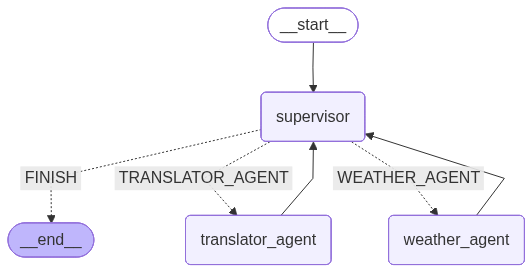

In [ ]:
# 그래프 컴파일
multi_agent_graph_conditional = graph_cond.compile()
multi_agent_graph_conditional

In [ ]:
# 디버깅용 함수(출력용 함수)
def print_stream_conditional(stream) :

  last_len = -1 # 직전 메세지 개수를 저장하기 위한 변수 (처음에는 -1)

  for s in stream :
    msgs = s["messages"] # 현재 상태의 메세지 리스트

    # 메세지가 늘지 않았다면, 다음 state로 넘어감
    if len(msgs) == last_len :
      continue

    # 메세지가 추가된 경우
    last_len = len(msgs)
    msgs[-1].pretty_print()

In [ ]:
# 1. 날씨 질문
print_stream_conditional(
    multi_agent_graph_conditional.stream(
        {"messages" : [("user", "서울 날씨 알려줘.")]},
        stream_mode = "values" # 메세지 필드만 전달
    )
)

================================ Human Message =================================

서울 날씨 알려줘.
================================== Ai Message ==================================

[WEATHER_AGENT] 서울은 오늘 흐리고 약간 쌀쌀합니다.


In [ ]:
# 2. 날씨 + 번역 요청
print_stream_conditional(
    multi_agent_graph_conditional.stream(
        {"messages" : [("user", "서울 날씨 알려주고, 마지막에 영어로도 번역해줘.")]},
        stream_mode = "values" # 메세지 필드만 전달
    )
)

================================ Human Message =================================

서울 날씨 알려주고, 마지막에 영어로도 번역해줘.
================================== Ai Message ==================================

[WEATHER_AGENT] 서울은 오늘 흐리고 약간 쌀쌀합니다.
================================== Ai Message ==================================

Seoul is cloudy and a bit chilly today.


In [ ]:
# 3. 번역만 질문
# 2. 날씨 + 번역 요청
print_stream_conditional(
    multi_agent_graph_conditional.stream(
        {"messages" : [("user", "다음 문장을 영어 문장을로 바꿔줘 : 안녕하세요")]},
        stream_mode = "values" # 메세지 필드만 전달
    )
)

================================ Human Message =================================

다음 문장을 영어 문장을로 바꿔줘 : 안녕하세요
================================== Ai Message ==================================

Hello.




### (2) Command 기반 Handoff
> LangGraph에서는 `Command(goto="다음_노드", graph=Command.PARENT, update=...)` 형태로 표현할 수 있음
> - `goto` : 다음에 실행할 노드(또는 에이전트 이름)
> - `graph=Command.PARENT` : “부모 그래프로 돌아가서 그 안에서 이동”
> - `update` : 상태 업데이트 (예: 새 메시지)

In [ ]:
from langgraph.types import Command # 랭그래프에서 제어 명령을 담당하는 타입

- 상태 클래스 정의

In [ ]:
class AgentStateCmd(TypedDict):
    """
    - Multi-Agent 그래프에서 'State'의 구조를 정의하는 데이터 틀.
    """

    # 메시지는 LangChain 메시지(BaseMessage)의 리스트
    messages: Annotated[Sequence[BaseMessage], add_messages]

    # Supervisor가 만든 전체 plan ("weather_only" 등)
    plan: str

    # Worker 실행 단계 (0 → 시작 / 1 → 첫 작업 끝 / 2 → 두 번째 작업 끝 …)
    step: int

- 워커 생성 (weather & Translator)

In [ ]:
# Worker : Weather Agent
def weather_agent_cmd(state : AgentStateCmd) -> AgentStateCmd :

  # state에서 사용자 질의를 찾기
  first_human = next(m for m in state["messages"] if isinstance(m, HumanMessage))

  # 도시명 추출
  city = extract_city(first_human)

  # 날씨 Tool 호출 - 도시를 입력 받으면, 날씨에 대한 정보를 반환하는 Tool
  weather_text = get_weather.invoke({"city" : city})

  return {
      "messages" : [AIMessage(content = f"[WEATHER_AGENT] {weather_text}")],
      "plan" : state.get("plan", ""),   # 기존 plan 유지
      "step" : state.get("step", 0) + 1 # 스텝 증가
  }

In [ ]:
# Worker : Translator Agent
def translator_agent_cmd(state : AgentStateCmd) -> AgentStateCmd :

  # 전달 받은 state에서 번역 대상 메세지를 변수에 할당
  last_text = state["messages"][-1].content

  # llm에게 전달 (agent 세팅)
  res = llm.invoke(f"[TRANSLATOR_AGENT]\n다음 내용을 영어 문장으로 자연스럽게 번역해줘 : \n {last_text}")

  return {
      "messages" : [AIMessage(content = res.content)],
      "plan" : state.get("plan", ""),   # 기존 plan 유지
      "step" : state.get("step", 0) + 1 # 스텝 증가
  }

- Supervisor 구현 (Command로 직접 handoff)

In [ ]:
def supervisor_cmd(state : AgentStateCmd) -> Command :

  # 최초 호출인지 아닌지를 판단해서, plan(지서서)을 도출해보기
  step = state.get("step", 0) # 현재 단계
  plan = state.get("plan", "") # 지시서(plan)

  if step == 0 and not plan : # 최초 호출인 경우,
    # state에서 사용자 질의를 찾기 - 첫 번째 메세지 객체를 반환
    first_human = next(m for m in state["messages"] if isinstance(m, HumanMessage))

    # plan 도출
    plan = extract_plan(first_human.content)

  # plan + step 기반 분기
  # 1) plan == "weather_only" 인 경우
  if plan == "weather_only":
      if step == 0 :
        goto = "weather_agent_cmd"
      else :
        goto = END

  # 2) plan == "translate_only" 인 경우
  elif plan == "translate_only":
      if step == 0 :
        goto = "translator_agent_cmd"
      else :
        goto = END

  # 3) plan == "weather_then_translate" 인 경우
  elif plan == "weather_then_translate":
      if step == 0 :
        goto = "weather_agent_cmd"    # 첫 번째 단계: 날씨 조회 Worker 실행
      elif step == 1 :
        goto = "translator_agent_cmd" # 두 번째 단계: 번역 Worker 실행
      else :
        goto = END                    # 그 이후 단계: 더 이상 할 일 없음

  else :
    goto = END

  # 수퍼바이저 → 메세지를 생성하지 않음 (다음에 어디로 가야할지랑 plan, step만 세팅해서 반환)
  return Command(
      goto = goto, # 다음 실행할 노드(또는 END)
      update = {"plan" : plan, "step" : step}, # 상태에 반영할 값
      # graph = Command.PARENT  # 서브그래프를 부모그래프로 점프할 때 세팅하는 값
  )

In [ ]:
# 그래프 구성

# 뼈대 만들어주기
graph_cmd = StateGraph(AgentStateCmd)

# 그래프에 노드 등록
graph_cmd.add_node("supervisor_cmd", supervisor_cmd)             # 수퍼바이저 노드(감독자 노드)
graph_cmd.add_node("weather_agent_cmd", weather_agent_cmd)       # 날씨 담당 Worker
graph_cmd.add_node("translator_agent_cmd", translator_agent_cmd) # 번역 담당 Worker
# route를 기반으로 점프

# 그래프 일반 엣지 연결
graph_cmd.add_edge(START, "supervisor_cmd")
graph_cmd.add_edge("weather_agent_cmd", "supervisor_cmd")
graph_cmd.add_edge("translator_agent_cmd", "supervisor_cmd")
graph_cmd.add_edge("supervisor_cmd", END)

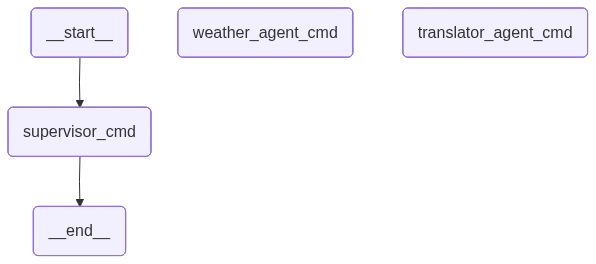

In [ ]:
# 그래프 컴파일
multi_agent_graph_command = graph_cmd.compile()
multi_agent_graph_command

In [ ]:
# 디버깅용 함수(출력용 함수)
def print_stream_command(stream) :

  last_len = -1 # 직전 메세지 개수를 저장하기 위한 변수 (처음에는 -1)

  for s in stream :
    msgs = s["messages"] # 현재 상태의 메세지 리스트

    # 메세지가 늘지 않았다면, 다음 state로 넘어감
    if len(msgs) == last_len :
      continue

    # 메세지가 추가된 경우
    last_len = len(msgs)
    msgs[-1].pretty_print()

In [ ]:
# 1. 날씨 질문
print_stream_command(
    multi_agent_graph_command.stream(
        {"messages" : [("user", "서울 날씨 알려줘.")]},
        stream_mode = "values" # 메세지 필드만 전달
    )
)

================================ Human Message =================================

서울 날씨 알려줘.
================================== Ai Message ==================================

[WEATHER_AGENT] 서울은 오늘 흐리고 약간 쌀쌀합니다.


In [ ]:
# 2. 날씨 + 번역 요청
print_stream_command(
    multi_agent_graph_command.stream(
        {"messages" : [("user", "서울 날씨 알려주고, 마지막에 영어로도 번역해줘.")]},
        stream_mode = "values" # 메세지 필드만 전달
    )
)

================================ Human Message =================================

서울 날씨 알려주고, 마지막에 영어로도 번역해줘.
================================== Ai Message ==================================

[WEATHER_AGENT] 서울은 오늘 흐리고 약간 쌀쌀합니다.
================================== Ai Message ==================================

Seoul is cloudy and a bit chilly today.


In [ ]:
# 3. 번역만 질문
# 2. 날씨 + 번역 요청
print_stream_command(
    multi_agent_graph_command.stream(
        {"messages" : [("user", "다음 문장을 영어 문장을로 바꿔줘 : 안녕하세요")]},
        stream_mode = "values" # 메세지 필드만 전달
    )
)

================================ Human Message =================================

다음 문장을 영어 문장을로 바꿔줘 : 안녕하세요
================================== Ai Message ==================================

Hello.


## 고급 에이전트 RAG
> Basic RAG
> - 지식 저장소에서 관련 정보를 검색한 후, LLM이 답변을 생성해내는 구조
> - 한계 : 항상 동일한 개수의 문서를 가져오기 때문에, 복잡한 질문에는 충분하지 않다.

> Agentic RAG
> - ReAct 패턴의 LLM + 도구 → 반복적으로 호출되면서 검색과 생성 단계를 유연하게 수행할 수 있는 구조
> - ex. 검색된 문서가 부족 → 추가 검색 수행, 웹 검색 호출 등을 수행 → 충분한 정보를 얻은 후 답변을 생성

### RAG 전략
- Adaptive RAG
  - 사용자 질의를 [ 질문 난이도, 사용자 요구 ]에 따라서 검색 단계를 조절하는 전략
  > 예를 들어,
  > - 간단한 질문에는 빠르게 한 번만 검색
  > - 복잡한 질문이나 적합한 문서가 없음 → 반복적으로 검색을 수행

- CRAG (Corrective RAG)
  - 검색 된 문서의 품질을 평가하는데, 필요한 경우 외부 검색 도구를 다시 호출해서 문서를 보완하는 전략

- Self-RAG
  - 모델이 스스로 검색한 문서 + 생성한 답변의 품질을 평가
  - 필요 시 재검색하거나, 답변을 수정함
  - 초기 답변 생성자, 평가자, 수정자 등 정의